# 03 - web scraping and data transformations

1. [The TSA posts passenger numbers](https://www.tsa.gov/coronavirus/passenger-throughput) in a table but there is no download or API option. We can use BeautifulSoup to parse this table.
1. Transform the TSA passenger data in two ways to create two different charts
1. Create two charts inside this notebook with [Matplotlib](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

__Library reference__
- [BeautifulSoup]()
- [pandas]()
- [Matplot for pandas]()
- [Datetime format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes)

1. Turn the TSA's html table into a dataframe
    1. Create a list of column names
    1. Create a 2d array of data
    1. Format the data into two columns: date and value
1. Transform the data in two different ways for new different charts
1. Create two charts

In [24]:
# !pipenv uninstall matplotlib

In [42]:
#### Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Turn the TSA's html table into a dataframe

In [25]:
# get html from from page
tsa_r = requests.get('https://www.tsa.gov/coronavirus/passenger-throughput')

In [26]:
# create a beautifulsoup object
tsa_bs = BeautifulSoup(tsa_r.text)

#### table tag
![table selected](assets/table.png)

### a. Create a list column names

In [27]:
# turn thead into a column list
thead = tsa_bs.find('thead')

In [28]:
# then find all th elements (because there is only 1 row)
ths = thead.find_all('th')

In [29]:
# and loop through each th to extract the text for a list
tsa_col = []
for th in ths:
    # remove trailing whitespace 
    tsa_col.append(th.text.strip())

In [30]:
tsa_col

['Date',
 '2021 Traveler Throughput',
 '2020 Traveler Throughput',
 '2019 Traveler Throughput']

### b. Create a 2d array of data
![tbody example](assets/tbody.png)

In [31]:
# turn data into an array of arrays (2d array)
tbody = tsa_bs.find('tbody')

In [32]:
# turn tr tags into a list
trs = tbody.find_all('tr')

In [33]:
# create a list of td tags inside each tr list
tr_list = []
for tr in trs:
    tds = tr.find_all('td')
    # and loop through each td to extract the text
    td_list = []
    for td in tds:
        # remove any whitespace
        td_list.append(td.text.strip())
    # add each list of text values to the tr list 
    tr_list.append(td_list)

In [34]:
# Check the length of the list and the first couple of items
len(tr_list), tr_list[0:2]

(365,
 [['7/2/2021', '2,196,411', '718,988', '2,184,253'],
  ['7/1/2021', '2,147,090', '764,761', '2,088,760']])

### c. Format the data into two columns: date and value

In [35]:
# create a function that will generate dates of preceding years
def format_date(d, column_year):
    # turn string into date object so we can perform datetime calculations on it
    d = datetime.date(datetime.strptime(d, '%m/%d/%Y'))

    # how many years past
    year_delta = d.year - column_year

    # you can apply addition and subtraction to get x-number of dates from/since now
    d = d - timedelta(weeks=52*year_delta)

    return d

In [36]:
print(tr_list[0][1:])

['2,196,411', '718,988', '2,184,253']


In [37]:
# this double loop can be combined with the loop above that generates tr_list
# but i want to separate text extraction from formatting
passengers_per_day = []
# for each tr
for td_list in tr_list:
    # we need to find dates for 2020 and 2019 and align them with the html table format
    # turn string into date object so we can perform datetime calculations on it
    date_2021 = datetime.date(datetime.strptime(td_list[0], '%m/%d/%Y'))
    # the date for 2020 will be 52 weeks before 
    date_2020 = date_2021 - timedelta(weeks=52)
    # the date for 2019 will be 104 weeks before
    date_2019 = date_2021 - timedelta(weeks=104)
    # because the above is a repeatable process, how can move this to a function?
    
    date_list = [format_date(td_list[0], 2021),
                 format_date(td_list[0], 2020),
                 format_date(td_list[0], 2019)]
    
    # for each passenger column td_list[1:]
    for (index, td) in enumerate(td_list[1:]):
        # Create a new dictionary to populate with formatted date
        # index being the column that corresponds to the order of dates in the date_list above
        daily_passengers = {
            'date': date_list[index],
            'value': td.replace(',', '')
        }
        
        # if value does exist, change it to an integer (or else there will be an error on missing values)
        if(daily_passengers['value'] != ''):
            daily_passengers['value'] = int(daily_passengers['value'])
            
            # add each newly created dictionary to passengers_per_day list
            passengers_per_day.append(daily_passengers)

In [38]:
# turn passengers_per_day into a DataFrame with "date" "value" columns
df = pd.DataFrame(passengers_per_day)

# sort dates from latest to earliest
df = df.sort_values('date', ascending=True)

# delete duplicates
df = df.drop_duplicates(subset=['date'])

## 2. Transform the data in two different ways for two different charts
[What's moving average and why are they used? - Dallas FED](https://www.dallasfed.org/research/basics/moving.aspx)

### a. Calculate 7-day moving average

In [39]:
df.tail(7)

,date,value
18,2021-06-26,1918705
15,2021-06-27,2167380
12,2021-06-28,2066964
9,2021-06-29,1808306
6,2021-06-30,1920663
3,2021-07-01,2147090
0,2021-07-02,2196411


In [43]:
# write a function that takes the current date and 6 previous dates and averages them
def moving_average(row):
    sum_ = 0
    for i in range(0, 7):
        new_date = row['date'] - timedelta(days=i)
        sum_ = sum_ + df[df['date'] == new_date]['value'].item()
    row['7day_average'] = int(sum_ / 7)
    return row

In [49]:
# calculate 7-day moving average in a new column
df_average = df[7:].apply(moving_average, axis=1, result_type='reduce')
df_average = df_average.set_index('date')

### b. Group data by weeks

In [45]:
def weekday_start(row):
    row['week_number'] = row['date'].isocalendar()[1]
    try:
        row['week_start'] = datetime.fromisocalendar(row['date'].year, row['date'].isocalendar()[1], 1)
    except:
        row['week_start'] = datetime.fromisocalendar(row['date'].year, 1, 1)
    return row

In [46]:
df_weeks = df.apply(weekday_start, axis=1, result_type='reduce')

In [58]:
df_by_week = pd.DataFrame(df_weeks.groupby('week_start')['value'].sum())

## 3. Create two charts - one for 7-day moving average and one for week totals

<AxesSubplot:xlabel='date'>

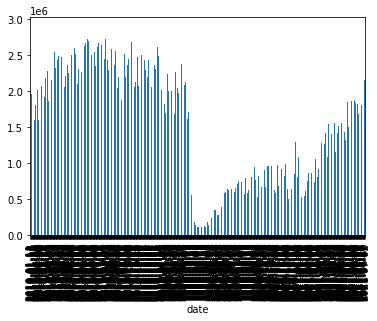

In [80]:
plt.figure()
df_average['value'].plot(kind='bar')

### a. 7-day moving average

<AxesSubplot:xlabel='date'>

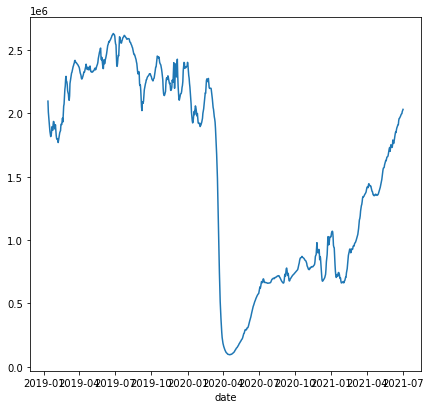

In [78]:
# plot a 7-day average chart
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
df_average['7day_average'].plot(ax=ax)

### b. By weekly totals

In [56]:
df_weeks.dtypes

date                   object
value                   int64
week_number             int64
week_start     datetime64[ns]
dtype: object

<AxesSubplot:xlabel='week_start'>

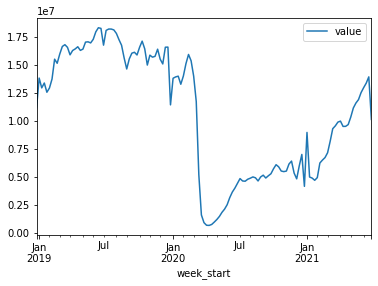

In [61]:
# plot as weeks
plt.figure
df_by_week.plot()